In [1]:
import numpy as np
np.set_printoptions(precision=2,suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
from BLEanalysis.signals import Signals
from BLEanalysis.angleinference import AnglesUsePatternMeans as Angles, getSample

#We'll use this dataset as 'training' data (to provide the pattern):
sigs = Signals("noamploc2long.log",'d',angleOffset = 38)
sigs_test = Signals("/home/mike/Documents/Research/bluetooth_experiments/March 26 2025 Field Trial/Range Trials/2.log",'c',angleOffset=-7)
angles = Angles(sigs,noisevar=10**2)
angles_testset = Angles(sigs_test,noisevar=10**2)
sigs.summarise()

2025-06-17 16:38:20.744516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750174700.817736   14863 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750174700.832747   14863 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750174700.962838   14863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750174700.962863   14863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750174700.962865   14863 computation_placer.cc:177] computation placer alr

Standardising angles and times (shifting by 38.00 degrees)
Standardising angles and times (shifting by -7.00 degrees)
Transmitter       Number of records
        d                39557


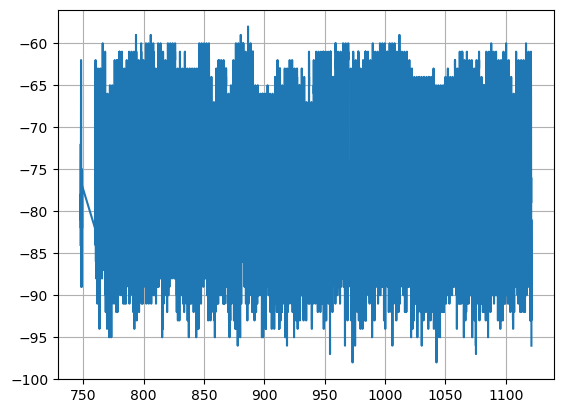

In [2]:
plt.plot(sigs.data[:20000,3]/1000,sigs.data[:20000,0])
plt.grid()

In [3]:
#We'll use this dataset for testing
testsigs = Signals("/home/mike/Documents/Research/bluetooth_experiments/March 26 2025 Field Trial/Range Trials/2.log",'c',angleOffset=100)
#I think it looks like there's a -7 degree offset between this and the data in sigs

Standardising angles and times (shifting by 100.00 degrees)


# Note on packet loss

We definitely have a not-at-random packet loss; i.e. at lower signal strengths the packets are more likely to go missing.

The upshot can be clearly seen in this averaging plot, where the training set (recorded at a shorter range) has a greater apparent gain, while the test data is, in comparison, "squashed".

I did write an alternative attempt (although using times not angles) to try to include this attenuation in the model, but it is a lot slower and includes more modelling unknowns -- and, as the regions where lots of data is missing is also the regions that aren't useful, it seems of limited utility to model that properly for now!

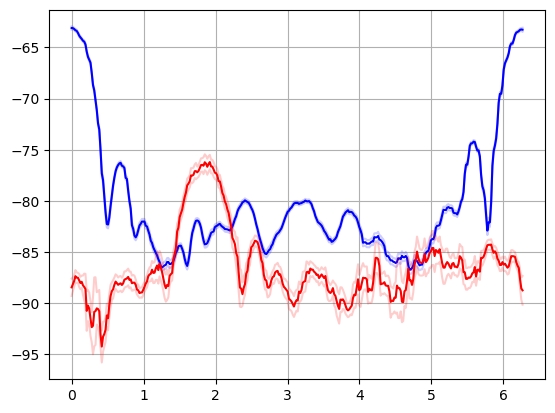

In [4]:
sigsavgs, _ = sigs.averageRSSIsAtAngle(smooth=True,detrend=True)#,smoothwindow=np.deg2rad(5))
#sigsavgs[:,1]-=np.max(sigsavgs[:,1])
plt.plot(sigsavgs[:,0],sigsavgs[:,1],'b-')
#plt.plot(2*np.pi-testavgs[:,0],testavgs[:,1],'b-')
plt.plot(sigsavgs[:,0],sigsavgs[:,1]-sigsavgs[:,3]*1.96,'b-',alpha=0.2)
plt.plot(sigsavgs[:,0],sigsavgs[:,1]+sigsavgs[:,3]*1.96,'b-',alpha=0.2)
sigsavgs[np.argmax(sigsavgs[:,1]),0]

testavgs, _ = testsigs.averageRSSIsAtAngle(smooth=True,detrend=True)#,smoothwindow=np.deg2rad(5))
#testavgs[:,1]+=13 #-=np.max(testavgs[:,1])
plt.plot(testavgs[:,0],testavgs[:,1],'r-')
#plt.plot(2*np.pi-testavgs[:,0],testavgs[:,1],'b-')
plt.plot(testavgs[:,0],testavgs[:,1]-testavgs[:,3]*1.96,'r-',alpha=0.2)
plt.plot(testavgs[:,0],testavgs[:,1]+testavgs[:,3]*1.96,'r-',alpha=0.2)
testavgs[np.argmax(testavgs[:,1]),0]
plt.grid()

# The Demo

Here I'm just taking a simulated burst sample from the testsigs, then run the inference, and plot the result.

[-1350.     -1104.5455  -859.0909  -613.6364  -368.1818  -122.7273
   122.7273   368.1818   613.6364   859.0909  1104.5455  1350.    ]


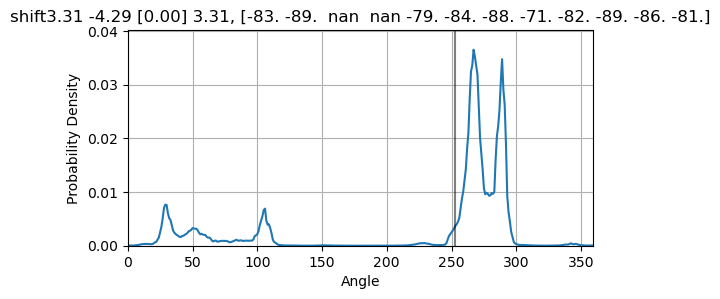

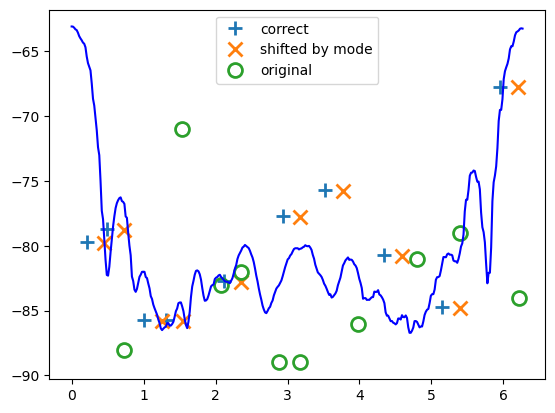

In [130]:
###GET A BURST SAMPLE
np.set_printoptions(precision=4)
intervals = np.linspace(-1350,1350,12) #the times we want to sample
#intervals = np.array([-600,-300,-150,0,150,300,600])
print(intervals)
accept_missing = 2 #set to 0 to have all packets included
#grab some example data, with no more than accept_missing received packets (must be within 10ms of target time).
while True:
    obs, obs_angles = getSample(testsigs.data,89e4+np.random.rand()*100000,intervals,raw=True,exclude_missing=10)
    if np.sum(np.isnan(obs))>accept_missing: continue
    #if np.any(obs<-90): continue
    #if np.abs(np.nanmean(obs_angles)-2.2)>0.5: continue
    break

#WE'LL USE THIS SAMPLE!!!
#obs,obs_angles=np.array([ np.nan, -91., -92., -77., -76., -86., -85.]),np.array([   np.nan, 1.1519, 1.4312, 1.7279, 1.9373, 2.2166, 2.5133])

####DO INFERENCE
logp,errs,avgAtAngles,keptObs = angles.infer(obs,obs_angles)
logp2,_,_,_ = angles_testset.infer(obs,obs_angles)

####CONVERT TO PROBABILITY DISTRIBUTION (FROM LOG PROB.)
p = np.exp(logp - np.max(logp))
p/= np.sum(p)

p2 = np.exp(logp2 - np.max(logp2))
p2/=np.sum(p2)

####PLOT
plt.figure(figsize=[6,2.8])
#Plot p
plt.plot(p)
#plt.plot(p2,'r--')
plt.grid()
plt.ylabel('Probability Density')
plt.xlabel('Angle')
plt.xlim([0,359])
plt.ylim([0,1.1*max(np.max(p),np.max(p2))])
plt.title("shift%0.2f %0.2f [%0.2f] %0.2f, %s" % (np.nanmean(obs_angles),np.max(logp),p[360-100-7],np.nanmean(obs_angles),str(obs)))
plt.vlines(360-7-100,0,np.max(p)*1.2,color='k',alpha=0.5) #True (ish)

#Plot signals
plt.figure()

#plot the 'true' observation locations
shiftangle = np.deg2rad(-107)
tempshift = np.mean(sigsavgs[np.rad2deg(shiftangle+obs_angles[~np.isnan(obs_angles)]).astype(int)%360,1])-np.nanmean(obs)
plt.plot((obs_angles+shiftangle)%(np.pi*2),obs+tempshift,'+',markersize=10,mew=2,label='correct')

#plot these observations shifted by the mode of the probability distribution, computed above.
shiftangle = np.deg2rad(np.argmax(p))
tempshift = np.mean(sigsavgs[np.rad2deg(shiftangle+obs_angles[~np.isnan(obs_angles)]).astype(int)%360,1])-np.nanmean(obs)
plt.plot((obs_angles+shiftangle)%(np.pi*2),obs+tempshift,'x',markersize=10,mew=2,label='shifted by mode')


#plot original
plt.plot(obs_angles,obs,'o',fillstyle='none',markersize=10,mew=2,label='original')

plt.plot(sigsavgs[:,0],sigsavgs[:,1],'b-')
plt.legend()

# Exploring how many / how often to sample...

In [95]:
spacings = [800]
for i in range(10): spacings.append(int(spacings[-1]*1.15))
spacings

[800, 919, 1056, 1214, 1396, 1605, 1845, 2121, 2439, 2804, 3224]

8
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

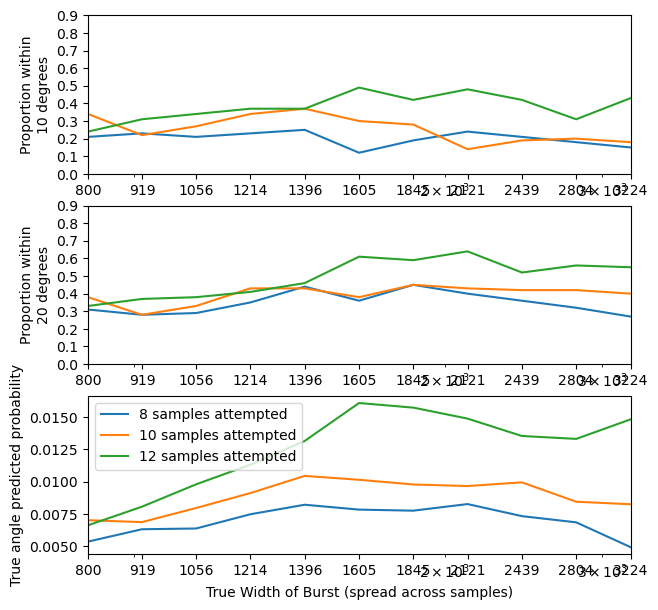

In [97]:

accept_missing = 2 #set to 0 to have all packets included
#grab some example data, with no more than accept_missing received packets (must be within 10ms of target time).
plt.figure(figsize=[7,7])
for Nsamples in [8,10,12]:
    print(Nsamples)
    allerrs_summary = []
    for intspacing in spacings:#[25,50,100,200,400,800,1600,3200,6400,12800]:
        errs = []
        ps = []
        intervals = np.linspace(-intspacing/2,intspacing/2,Nsamples)
        for samples in range(100):
            print(".",end="")
            while True:
                obs, obs_angles = getSample(testsigs.data,89e4+np.random.rand()*100000,intervals,raw=True,exclude_missing=25)
                if np.sum(np.isnan(obs))>accept_missing: continue
                #if np.abs(np.nanmean(obs_angles)-2.2)>0.5: continue
                break
            logp,_,_,_ = angles.infer(obs,obs_angles)
            p = np.exp(logp - np.max(logp))
            p/= np.sum(p)
            errs.append(np.argmax(logp)-(360-100-7))
            ps.append(np.mean(p[360-100-7-10:360-100-7+10]))
        allerrs_summary.append([intspacing,np.mean(np.abs(errs)<10),np.mean(np.abs(errs)<20),np.mean(ps)])
    allerrs_summary = np.array(allerrs_summary)
    plt.subplot(3,1,1)
    plt.plot(allerrs_summary[:,0],allerrs_summary[:,1],label="%d samples attempted" % Nsamples)
    #plt.xlabel('Extent (spread across samples)')
    plt.ylabel('Proportion within\n10 degrees')
    #plt.xlim([25,12800])
    plt.xlim([min(spacings),max(spacings)])
    plt.grid()
    plt.xscale('log')
    #ticks = [25,50,100,200,400,800,1600,3200,6400,12800]
    ticks = spacings
    plt.xticks(ticks,ticks)
    plt.yticks(np.arange(0,1,0.1))

    plt.subplot(3,1,2)
    plt.plot(allerrs_summary[:,0],allerrs_summary[:,2],label="%d samples attempted" % Nsamples)
    #plt.xlabel('Extent (spread across samples)')
    plt.ylabel('Proportion within\n20 degrees')
    #plt.xlim([25,12800])
    plt.xlim([min(spacings),max(spacings)])
    plt.grid()
    plt.yticks(np.arange(0,1,0.1))
    plt.xscale('log')
    #ticks = [25,50,100,200,400,800,1600,3200,6400,12800]
    ticks = spacings
    plt.xticks(ticks,ticks)
    plt.subplot(3,1,3)
    plt.plot(allerrs_summary[:,0],allerrs_summary[:,3],label="%d samples attempted" % Nsamples)
    plt.xlabel('True Width of Burst (spread across samples)')
    plt.ylabel('True angle predicted probability')
    plt.grid()
    #plt.xlim([25,12800])
    plt.xlim([min(spacings),max(spacings)])
    plt.xscale('log')
    plt.xticks(ticks,ticks)
plt.legend()

plt.subplot(3,1,1)
plt.grid()
plt.subplot(3,1,2)
plt.grid()
plt.subplot(3,1,3)
plt.grid()

Sampling all the observations +/- 100ms of the target seems a good idea?